<a href="https://colab.research.google.com/github/R1shiY/Projects/blob/main/Xylem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.nn.functional as F


In [51]:
real_samples = [
    [34.0202, -84.3090, 'Serratia marcescens', 'Low'],
    [34.2187, -84.1157, 'Serratia marcescens', 'Low'],
    [34.2187, -84.1157, 'Morganella morganii', 'High'],
    [34.2187, -84.1157, 'Staphylococcus saprophyticus', 'High'],
    [34.1873, -84.1468, 'Candida albicans', 'Low'],
    [34.1873, -84.1468, 'Serratia marcescens', 'Low'],
    [34.1873, -84.1468, 'Enterobacter cloacae', 'Low'],
    [34.1873, -84.1468, 'Serratia marcescens', 'Low'],
    [34.1293, -84.2384, 'Serratia marcescens', 'Low'],
    [34.1293, -84.2384, 'Serratia marcescens', 'Low'],
    [34.1293, -84.2384, 'Enterobacter cloacae', 'Low'],
    [34.1293, -84.2384, 'Trichophytum rubrum', 'High']
]

df = pd.DataFrame(real_samples, columns=['latitude', 'longitude', 'bacteria_type', 'concentration'])


In [36]:
real_samples = [
    [34.0202, -84.3090, 'Serratia marcescens', 'Low'],                          # FSA
    [34.2187, -84.1157, 'Serratia marcescens', 'Low'],                          # Alliance
    [34.2187, -84.1157, 'Morganella morganii', 'High'],                         # Alliance
    [34.2187, -84.1157, 'Staphylococcus saprophyticus', 'High'],               # Alliance
    [34.1873, -84.1468, 'Candida albicans', 'Low'],                             # Gym FW
    [34.1873, -84.1468, 'Serratia marcescens', 'Low'],                          # Gym FW
    [34.1873, -84.1468, 'Enterobacter cloacae', 'Low'],                         # Gym TW
    [34.1873, -84.1468, 'Serratia marcescens', 'Low'],                          # Gym TW
    [34.1293, -84.2384, 'Serratia marcescens', 'Low'],                          # School FW
    [34.1293, -84.2384, 'Serratia marcescens', 'Low'],                          # School TW
    [34.1293, -84.2384, 'Enterobacter cloacae', 'Low'],                         # School TW
    [34.1293, -84.2384, 'Trichophytum rubrum', 'High']                          # School TW
]

df = pd.DataFrame(real_samples, columns=['latitude', 'longitude', 'bacteria_type', 'concentration'])

df.head()


,latitude,longitude,bacteria_type,concentration
0,34.0202,-84.3090,Serratia marcescens,Low
1,34.2187,-84.1157,Serratia marcescens,Low
2,34.2187,-84.1157,Morganella morganii,High
3,34.2187,-84.1157,Staphylococcus saprophyticus,High
4,34.1873,-84.1468,Candida albicans,Low


In [52]:
le_bacteria = LabelEncoder()
le_concentration = LabelEncoder()

df['bacteria_label'] = le_bacteria.fit_transform(df['bacteria_type'])
df['concentration_label'] = le_concentration.fit_transform(df['concentration'])

lat_mean, lat_std = df['latitude'].mean(), df['latitude'].std()
lon_mean, lon_std = df['longitude'].mean(), df['longitude'].std()

df['latitude_norm'] = (df['latitude'] - lat_mean) / lat_std
df['longitude_norm'] = (df['longitude'] - lon_mean) / lon_std


In [53]:
class BacteriaDataset(Dataset):
    def __init__(self, dataframe):
        self.X = dataframe[['latitude_norm', 'longitude_norm']].values.astype(np.float32)
        self.y_bacteria = dataframe['bacteria_label'].values.astype(np.int64)
        self.y_conc = dataframe['concentration_label'].values.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_bacteria[idx], self.y_conc[idx]

dataset = BacteriaDataset(df)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [54]:
class AdvancedClassifier(nn.Module):
    def __init__(self, num_bacteria, num_conc):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(2, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.bacteria_head = nn.Linear(16, num_bacteria)
        self.conc_head = nn.Linear(16, num_conc)

    def forward(self, x):
        x = self.shared(x)
        return self.bacteria_head(x), self.conc_head(x)

model = AdvancedClassifier(
    num_bacteria=len(le_bacteria.classes_),
    num_conc=len(le_concentration.classes_)
)

criterion_bacteria = nn.CrossEntropyLoss()
criterion_concentration = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


In [55]:
EPOCHS = 100
losses = []
accs_bacteria = []
accs_concentration = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    all_preds_b, all_labels_b = [], []
    all_preds_c, all_labels_c = [], []

    for X, y_b, y_c in dataloader:
        optimizer.zero_grad()
        out_b, out_c = model(X)

        loss_b = criterion_bacteria(out_b, y_b)
        loss_c = criterion_concentration(out_c, y_c)
        loss = loss_b + loss_c

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        all_preds_b.extend(out_b.argmax(1).tolist())
        all_labels_b.extend(y_b.tolist())
        all_preds_c.extend(out_c.argmax(1).tolist())
        all_labels_c.extend(y_c.tolist())

    acc_b = accuracy_score(all_labels_b, all_preds_b)
    acc_c = accuracy_score(all_labels_c, all_preds_c)

    losses.append(epoch_loss / len(dataloader))
    accs_bacteria.append(acc_b)
    accs_concentration.append(acc_c)

    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch+1}: Loss={losses[-1]:.4f}, Bacteria Acc={acc_b:.2f}, Concentration Acc={acc_c:.2f}")


Epoch 1: Loss=2.3271, Bacteria Acc=0.33, Concentration Acc=0.75
Epoch 11: Loss=1.9192, Bacteria Acc=0.50, Concentration Acc=0.75
Epoch 21: Loss=1.8256, Bacteria Acc=0.50, Concentration Acc=0.75
Epoch 31: Loss=1.8144, Bacteria Acc=0.50, Concentration Acc=0.83
Epoch 41: Loss=1.7363, Bacteria Acc=0.42, Concentration Acc=0.75
Epoch 51: Loss=1.9432, Bacteria Acc=0.50, Concentration Acc=0.75
Epoch 61: Loss=1.7830, Bacteria Acc=0.50, Concentration Acc=0.83
Epoch 71: Loss=1.6168, Bacteria Acc=0.50, Concentration Acc=0.75
Epoch 81: Loss=1.5834, Bacteria Acc=0.58, Concentration Acc=0.83
Epoch 91: Loss=1.6199, Bacteria Acc=0.58, Concentration Acc=0.83
Epoch 100: Loss=1.5007, Bacteria Acc=0.58, Concentration Acc=0.83


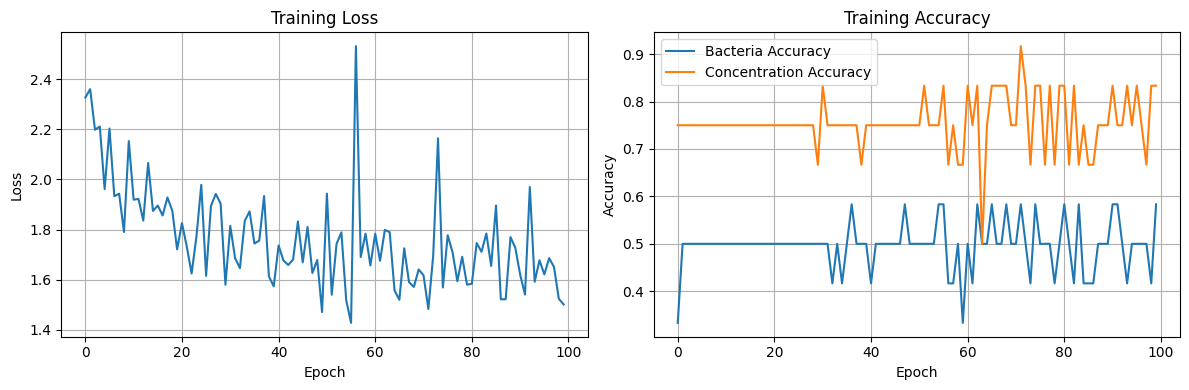

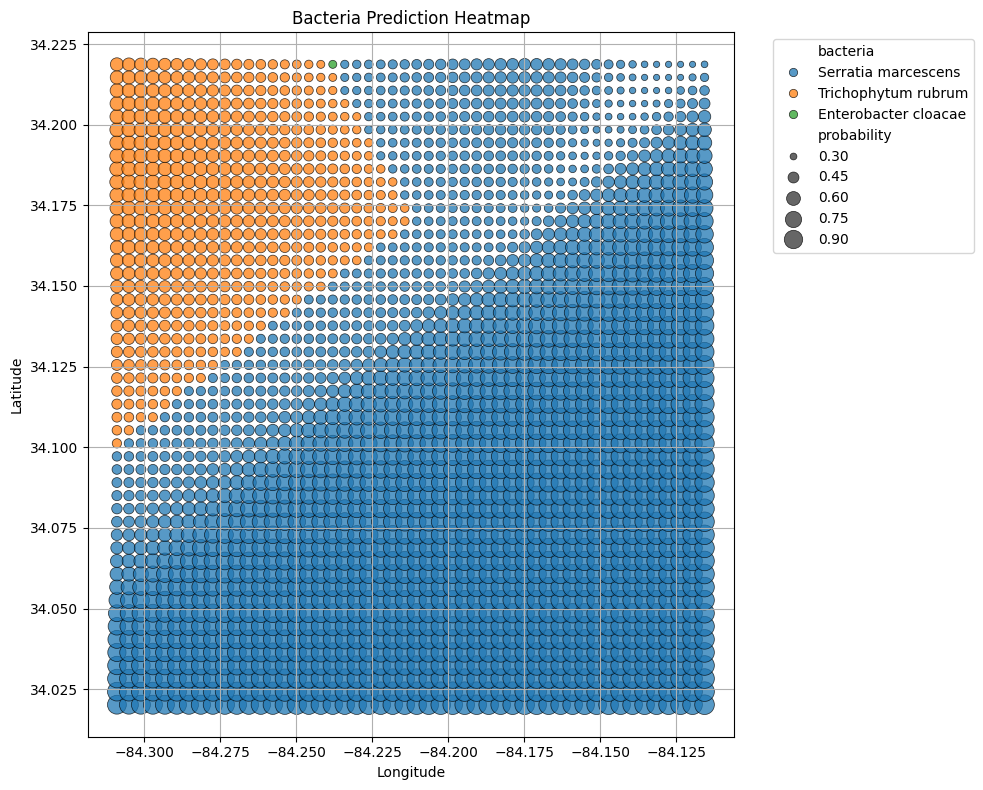

In [61]:
import seaborn as sns
import matplotlib.cm as cm

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accs_bacteria, label='Bacteria Accuracy')
plt.plot(accs_concentration, label='Concentration Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


def generate_prediction_heatmap():

    lat_range = np.linspace(df['latitude'].min(), df['latitude'].max(), 50)
    lon_range = np.linspace(df['longitude'].min(), df['longitude'].max(), 50)

    heatmap_data = []

    for lat in lat_range:
        for lon in lon_range:
            lat_norm = (lat - lat_mean) / lat_std
            lon_norm = (lon - lon_mean) / lon_std
            input_tensor = torch.tensor([[lat_norm, lon_norm]], dtype=torch.float32)

            model.eval()
            with torch.no_grad():
                out_b, _ = model(input_tensor)
                probs_b = F.softmax(out_b, dim=1).squeeze().numpy()
                top_idx = probs_b.argmax()
                top_bacteria = le_bacteria.inverse_transform([top_idx])[0]
                prob = probs_b[top_idx]

            heatmap_data.append([lat, lon, top_bacteria, prob])


    heat_df = pd.DataFrame(heatmap_data, columns=['latitude', 'longitude', 'bacteria', 'probability'])


    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=heat_df,
        x='longitude', y='latitude',
        hue='bacteria',
        size='probability',
        sizes=(20, 200),
        palette='tab10',
        alpha=0.75,
        edgecolor='k'
    )
    plt.title("Bacteria Prediction Heatmap")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


generate_prediction_heatmap()


In [62]:
def predict_bacteria_with_concentration(lat, lon):
    lat_norm = (lat - lat_mean) / lat_std
    lon_norm = (lon - lon_mean) / lon_std
    input_tensor = torch.tensor([[lat_norm, lon_norm]], dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        out_b, out_c = model(input_tensor)

        probs_b = F.softmax(out_b, dim=1).squeeze().numpy()
        probs_c = F.softmax(out_c, dim=1).squeeze().numpy()

    bacteria_names = le_bacteria.inverse_transform(np.arange(len(probs_b)))
    conc_labels = le_concentration.inverse_transform(np.arange(len(probs_c)))

    top_conc_idx = probs_c.argmax()
    top_conc_label = conc_labels[top_conc_idx]
    top_conc_prob = probs_c[top_conc_idx]

    full_predictions = []
    for i, name in enumerate(bacteria_names):
        full_predictions.append({
            'bacteria': name,
            'bacteria_probability': probs_b[i],
            'predicted_concentration': top_conc_label,
            'concentration_probability': top_conc_prob
        })

    full_predictions = sorted(full_predictions, key=lambda x: x['bacteria_probability'], reverse=True)
    return full_predictions


In [ ]:
lat = float(input("Enter latitude: "))
lon = float(input("Enter longitude: "))
preds = predict_bacteria_with_concentration(lat, lon)

print("\nPredictions:")
for p in preds:
    print(f"  {p['bacteria']:<30} | Prob: {p['bacteria_probability']:.2%} | "
          f"Concentration: {p['predicted_concentration']} ({p['concentration_probability']:.2%})")
